In [1]:
import sys, os
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pyoperon as Operon
from iminuit import Minuit
from iminuit.cost import LeastSquares
import seaborn as sns
from sklearn.metrics import r2_score

sys.path.append('../')
import mvsr as mvsr
import analysis as ana

## Format the data

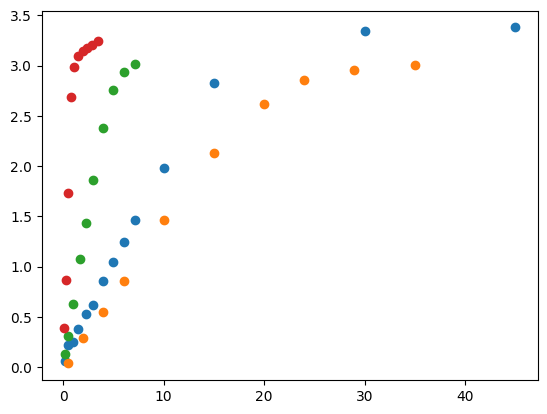

In [5]:
folder = "absorption/examples"

# Delete and recreate folder
if os.path.exists(f"{folder}"):
    shutil.rmtree(f"{folder}")
os.makedirs(f"{folder}")
n_example = 0

for i in range(4):
    data = pd.read_excel(f"absorption/molecule{i+1}.xlsx", sheet_name=0)
    abso = data.iloc[:, 2::4]

    peak = np.argmax(data['Unnamed: 2'])
    n_example += 1
    x = [float(k.split("= ",1)[1].split("e",1)[0].replace(',', '.')) for k in data.keys()[0::4]]
    y =  abso.iloc[peak].values
    plt.scatter(x, y)
    ana.save_2D_example(x, y, f'{folder}/example{i}.csv')

## Run MvSR

In [9]:
agg_best_str, all_best_str = mvsr.MultiViewSR(folder, maxL=15, maxD=3, generations=1000, seed=5,
                                              OperationSet=Operon.NodeType.Exp|Operon.NodeType.Log, verbose=False, explicit_params=False)

func, func_str, initial_guess = ana.convert_string_to_func(agg_best_str, 1)
func_str

'log(A/(B + exp(-C*X1)))'

[0.99834903822755, 0.9989523248293446, 0.9989551242461789, 0.998658934827092]

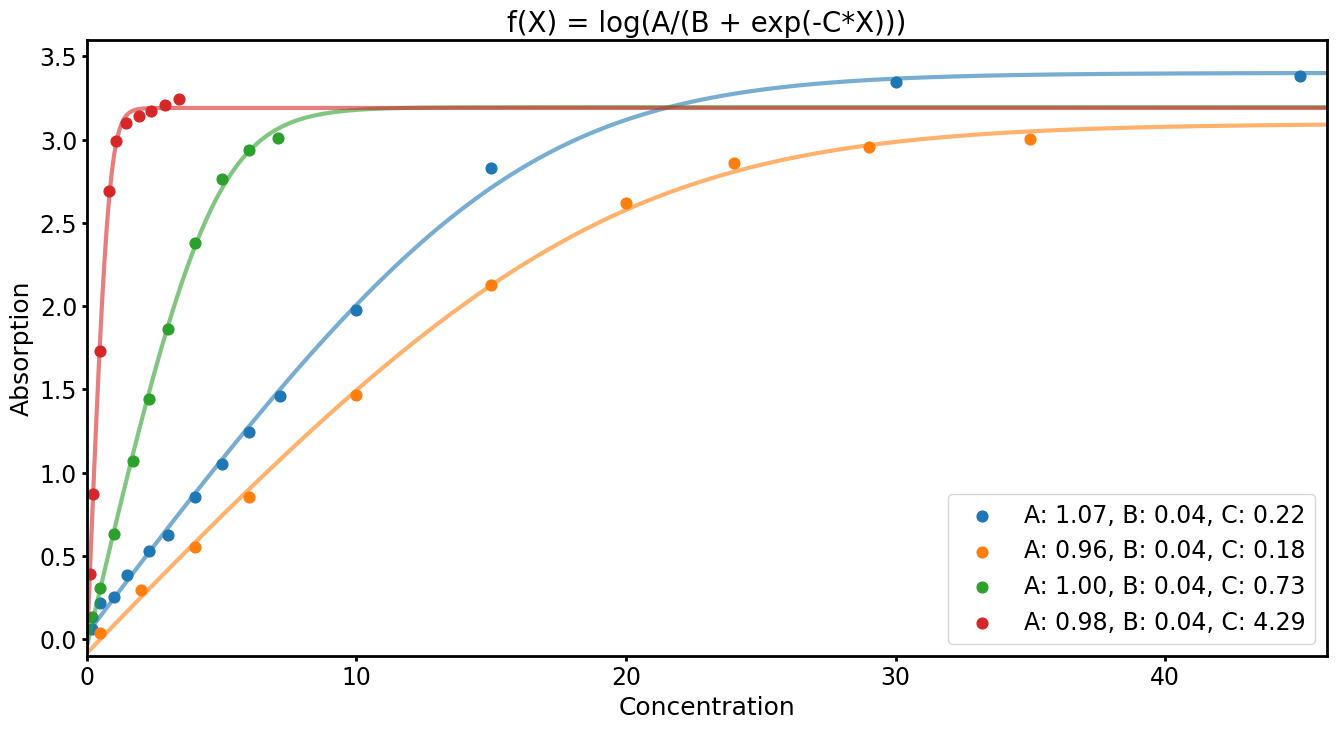

In [10]:
ana.refit_and_plot(folder, func, func_str, initial_guess,
                   [0, 46], [-.1, 3.6],
                   ['Concentration', 'Absorption'],
                   folder[:folder.find('/')])

## Simplify the function and create plot

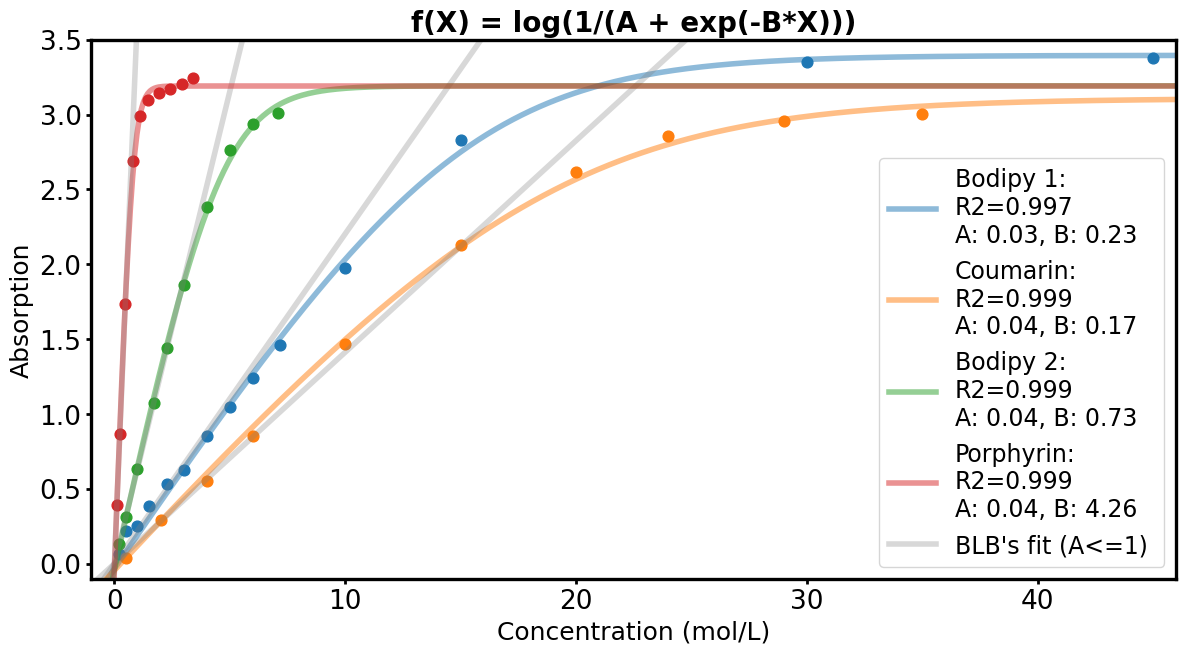

In [11]:
def simplified(X, A, B):
    return np.log(1/(A + np.exp(-B * X[0])))

def line(X, A):
    return A * X[0]

simplified_str = 'log(1/(A + exp(-B*X1)))'
simplified_guess =  {'A': 0.03, 'B': 2}

smooth = [np.linspace(-1, 46, 500).T]
color_palette = sns.color_palette("tab10")
all_sets = np.sort([x for x in os.listdir(folder) if 'csv' in x])
fig, axes = plt.subplots(1, 1, figsize=(14,7))

names = ['Bodipy 1', 'Coumarin', 'Bodipy 2', 'Porphyrin']

all_sets = all_sets[:len(color_palette)]

for idx, file in enumerate(all_sets):

    df = pd.read_csv(f'{folder}/{file}')
    X = df.iloc[:, :-1].values.T
    y = df.yaxis.values

    masko = y <= 1
    X_lin = df.iloc[:, :-1][masko].values.T
    y_lin = y[masko]
    
    least_squares = LeastSquares(X, y, 1, simplified)
    fit = Minuit(least_squares, **simplified_guess)
    fit.migrad()

    least_squares2 = LeastSquares(X_lin, y_lin, 1, line)
    fit2 = Minuit(least_squares2, **{'A' : 1})
    fit2.migrad()
    
    y_pred = simplified(X, *fit.values)
    r2 = r2_score(y, y_pred)
    sx = np.sort(X, axis=0)
    
    dic = fit.values.to_dict()
    display = [f'{x}: {dic.get(x):.2f}' for x in dic]
    display = ", ".join([str(item) for item in display])

    label = f"{names[idx]}:\nR2={r2:.3f}\n{display}"
    
    plt.scatter(X.flatten(), y, color=color_palette[idx], s=60)
    plt.plot(smooth[0], simplified(smooth, *fit.values).flatten(),\
             color=color_palette[idx], alpha=.5, linewidth=4, label=label)

    if idx!=3:
        plt.plot(smooth[0], line(smooth, *fit2.values).flatten(),\
                 color='gray', alpha=.3, linewidth=4)
    else:
        plt.plot(smooth[0], line(smooth, *fit2.values).flatten(),\
                 color='gray', alpha=.3, linewidth=4, label='BLB\'s fit (A<=1) ')
    
    plt.ylim(-.1, 3.5)
    plt.xlim(min(smooth[0]), max(smooth[0]))

title = f"f(X1) = {simplified_str}".replace("X1", "X")
plt.title(title, fontsize=20, fontweight='bold')
plt.xlabel('Concentration (mol/L)', fontsize=18)
plt.ylabel('Absorption', fontsize=18)

for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.4)

axes.tick_params(width=1.7)
axes.tick_params(labelsize=13)
axes.legend(fontsize = 12)

axes.tick_params(width=2,labelsize=19)
plt.legend(fontsize=17)
plt.savefig(f"plots/absorption_simplified.pdf", bbox_inches='tight')